In [49]:
import numpy as np
import gym
from gym import spaces

EPS = 0.05
X1_BOUND = 3
X2_BOUND = 1.5
X3_BOUND = 1.5
U_BOUND = 10


class SingleLinkManipulator(gym.Env):

    # metadata　= {
    #     "render_modes": ["rgb_array"]
    # }

    def __init__(self, N, B, M, Kb, R, L):
        self.N = N
        self.B = B
        self.M = M
        self.Kb = Kb
        self.R = R
        self.L = L
        self.dt = 0.1
        self.t = 0.0
        self.x1 = 0.0
        self.x2 = 0.0
        self.x3 = 0.0

        self.action_space = spaces.Box(
            low=-U_BOUND, high=U_BOUND, dtype=np.float32, shape=(1,))
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([X1_BOUND, X2_BOUND, X3_BOUND]),
            dtype=np.float32
        )

    def _signal(self):
        # return (np.pi/2.0)*np.sin(8.0*np.pi*self.t/5.0)
        return np.pi/3.0

    def _get_obs(self):
        return np.array([self.x1, self.x2, self.x3])

    def _normalize_x1(self, x1):
        x1 = x1 % np.pi
        return x1

    def step(self, u):
        N = self.N
        B = self.B
        M = self.M
        Kb = self.Kb
        R = self.R
        L = self.L
        dt = self.dt

        # clip action (voltage can't be negative)
        u = np.clip(u, -U_BOUND, U_BOUND)

        # calculate update parameters
        x1_dot = self.x2
        x2_dot = -(N/M)*np.sin(self.x1) - (B/M)*self.x2 + (self.x3/M)
        x3_dot = -(Kb/L)*self.x2 - (R/L)*self.x3 + (u/L)

        # update parameters
        # self.x1 = self._normalize_x1(self.x1 + x1_dot*dt)
        self.x1 = np.clip(self.x1 + x1_dot*dt, 0, X1_BOUND)
        self.x2 = np.clip(self.x2 + x2_dot*dt, 0, X2_BOUND)
        self.x3 = np.clip(self.x3 + x3_dot*dt, 0, X3_BOUND)

        self.t += dt

        # calculate results
        x1_expected = self._signal()
        # reward = 1 if np.abs(x1_expected - self.x1) <= EPS else 0
        reward = - ((self.x1 - x1_expected)**2)

        return self._get_obs(), reward, False, False, {}

    def reset(self, state=(0.0,0.0,0.0)):
        self.t = 0
        if state == None:
            self.x1, self.x2, self.x3 = self.observation_space.sample()
        else:
            assert type(state) == type((0.0, 0.0, 0.0))
            assert len(state) == 3
            self.x1, self.x2, self.x3 = state
        return self._get_obs(), {}


In [50]:
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

import os


In [51]:
# constants
gamma = 0.99

# state table values init
X1 = np.linspace(0, X1_BOUND, 30)
X2 = np.linspace(0, X2_BOUND, 15)
X3 = np.linspace(0, X3_BOUND, 15)
N1 = X1.size
N2 = X2.size
N3 = X3.size

# action space init
U = np.linspace(-U_BOUND, U_BOUND, 40)

# optimal policy and value init
policy = np.zeros((N1, N2, N3))
V = np.full((N1, N2, N3), 0.0)


# parameter init
J = 1.625103
m = 0.506
M0 = 0.434
L0 = 0.305
R0 = 0.023
B0 = 16.25163
L = 25.0103
R = 5.0
Kt = Kb = 0.90
g = 9.8
M = J + m*L0*L0/3.0 + M0*L0*L0 + 2*M0*R0*R0/5/Kt
N = m*L0*g/2.0 + M0*L0*g/Kt
B = B0/Kt


# initialize env
env = SingleLinkManipulator(N, B, M, Kb, R, L)



/home/initdaemon/Code/ai/Major_Project/lib64/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [52]:
def find_nearest(array, value):
    # idx = np.searchsorted(array, value, side="left")
    # if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
    #     return idx-1
    # else:
    #     return idx
    return np.digitize(value, array)

temp = np.linspace(0,1,10)
print(temp[find_nearest(temp, 0.54)])


0.5555555555555556


In [53]:
for _ in range(10):
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                nextV = np.full((U.size), 0.0)
                state = (X1[i], X2[j], X3[k])
                for u in range(U.size):
                    env.reset(state)
                    new_state, _, _, _, _ = env.step(U[u])
                    x1, x2, x3 = new_state
                    x1 = find_nearest(X1, x1)-1
                    x2 = find_nearest(X2, x2)-1
                    x3 = find_nearest(X3, x3)-1
                    nextV[u] = V[x1, x2, x3]
                Vbest = np.max(nextV)
                reward =  -((env._signal() - X1[i])**2)
                V[i, j, k] = reward + gamma*Vbest


In [54]:
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            
            state = (X1[i], X2[j], X3[k])
            env.reset(state)
            for u in range(U.size):
                new_state, _, _, _, _ = env.step(U[u])
                x1, x2, x3 = new_state
                x1 = find_nearest(X1, x1) - 1
                x2 = find_nearest(X2, x2) - 1
                x3 = find_nearest(X3, x3) - 1
                nextV[u] = V[x1, x2, x3]
            Vbest_idx = np.argmax(nextV)
            policy[i, j, k] = U[Vbest_idx]


In [62]:
model = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(10, activation='softplus'),
    keras.layers.Dense(10, activation='softplus'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)

x_train = np.array([[0,0,0]])
y_train = np.array([0])

for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            x_train = np.append(x_train, [[i, j, k]], axis=0)
            y_train = np.append(y_train, policy[i, j, k])

x_train=  x_train[1:]
y_train=  y_train[1:]/U_BOUND

history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=100,
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                40        
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 2ms/step - loss: 2.0457 - mean_squared_error: 2.0457
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 1.0585 - mean_squared_error: 1.0585
Epoch 3/100
27/27 [==============================] - 0s 1ms/step - loss: 1.0134 - mean_squared_error: 

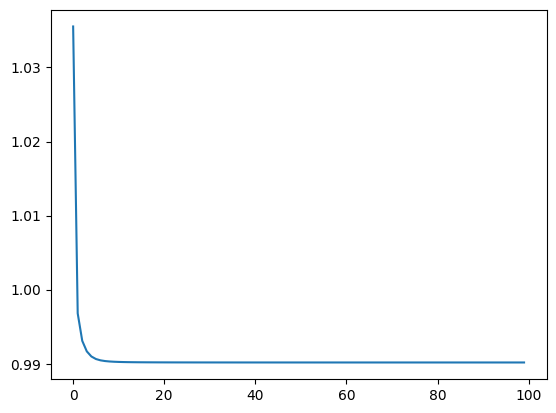

In [56]:
plt.plot(history.history['loss'])

In [57]:
x_train[:25],y_train[:25]

(array([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        [ 0,  0,  3],
        [ 0,  0,  4],
        [ 0,  0,  5],
        [ 0,  0,  6],
        [ 0,  0,  7],
        [ 0,  0,  8],
        [ 0,  0,  9],
        [ 0,  0, 10],
        [ 0,  0, 11],
        [ 0,  0, 12],
        [ 0,  0, 13],
        [ 0,  0, 14],
        [ 0,  1,  0],
        [ 0,  1,  1],
        [ 0,  1,  2],
        [ 0,  1,  3],
        [ 0,  1,  4],
        [ 0,  1,  5],
        [ 0,  1,  6],
        [ 0,  1,  7],
        [ 0,  1,  8],
        [ 0,  1,  9]]),
 array([-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ,  1.        ,  0.64102564,  0.33333333,  0.12820513,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ]))

(1, 3)
1/1 [==============================] - 0s 63ms/step
(1, 3)
1/1 [==============================] - 0s 23ms/step
(1, 3)
1/1 [==============================] - 0s 31ms/step
(1, 3)
1/1 [==============================] - 0s 25ms/step
(1, 3)
1/1 [==============================] - 0s 24ms/step
(1, 3)
1/1 [==============================] - 0s 27ms/step
(1, 3)
1/1 [==============================] - 0s 24ms/step
(1, 3)
1/1 [==============================] - 0s 28ms/step
(1, 3)
1/1 [==============================] - 0s 28ms/step
(1, 3)
1/1 [==============================] - 0s 23ms/step
(1, 3)
1/1 [==============================] - 0s 23ms/step
(1, 3)
1/1 [==============================] - 0s 24ms/step
(1, 3)
1/1 [==============================] - 0s 27ms/step
(1, 3)
1/1 [==============================] - 0s 26ms/step
(1, 3)
1/1 [==============================] - 0s 26ms/step
(1, 3)
1/1 [==============================] - 0s 27ms/step
(1, 3)
1/1 [==============================] - 0s 22ms/st

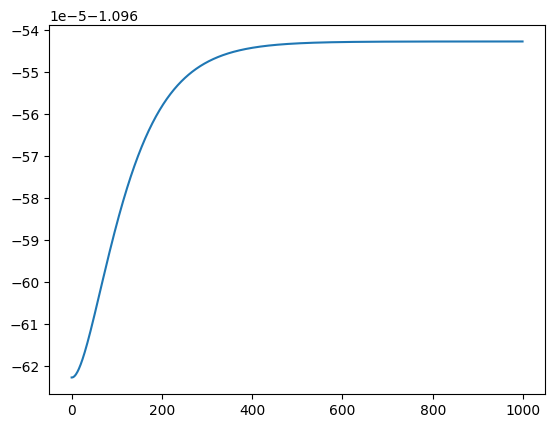

In [58]:
env.reset()
rewards = np.array([])
for eps in range(1000):
    state = env._get_obs()
    # print(state)
    # print(state.shape)
    print(np.atleast_2d(state).shape)
    action = model.predict((np.atleast_2d(state)).astype(np.float32))[0][0]
    # print(action.shape)
    action *= U_BOUND
    _ ,reward, _,_,_ = env.step(action)
    rewards = np.append(rewards, reward)

plt.plot(rewards) 

array([-1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654269, -1.09654269, -1.09654269, -1.09654269,
       -1.09654269, -1.09654268, -1.09654268, -1.09654268, -1.09654268,
       -1.09654268, -1.09654268, -1.09654268, -1.09654268, -1.09654268,
       -1.09654268, -1.09654268, -1.09654268, -1.09654268, -1.09654268,
       -1.09654268, -1.09654268, -1.09654268, -1.09654268, -1.09654268,
       -1.09654268, -1.09654268, -1.09654268, -1.09654268, -1.09

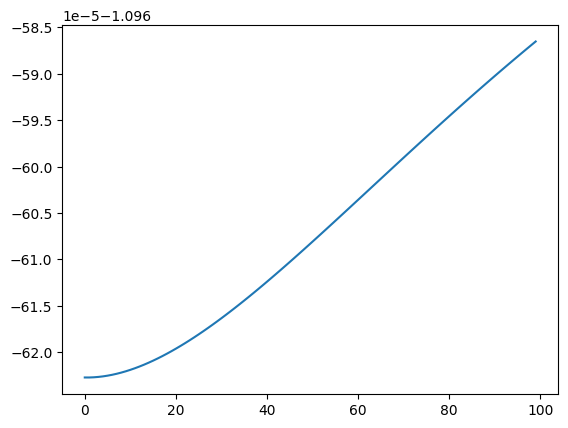

In [59]:
rewards2 = np.array([])

for r in range(rewards.shape[0]):
    if r%2 == 1:
        rewards2 = np.append(rewards2, rewards[r])

plt.plot(rewards[:100])
rewards[-100:]
